In [1]:
import pandas as pd
import os
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report,confusion_matrix, accuracy_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

os.chdir('C:\insta\data')
#from google.colab import drive
#drive.mount('/content/gdrive')

## Xgboost

### Model building

#### set parameters for model 

In [2]:
params = {}
params["silent"] = 1
params["objective"] = "binary:logistic"
params['eval_metric'] = 'auc'
params["eta"] = 0.19
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8
params["min_child_weight"] = 10
params["max_depth"] = 10
params["max_leaf_nodes"] = 100
params["scale_pos_weight"] = 1
params["nthread "] = 8
params["seed"] = 1000
plst = list(params.items())

num_rounds = 10

cutoff = 0.22




#### Use Training set for train and test

In [3]:
#train = pd.read_csv("gdrive/My Drive/Colab Notebooks/instacart/train.csv")
train = pd.read_csv("train.csv")
train = train.set_index(['user_id', 'product_id'])

X = train.drop('reordered', axis=1)
y = train.reordered.astype(np.int16)

train.head(5)
#y.head(5)     

,,user_num_orders,user_num_prods,user_num_distinct_prods,user_avg_num_prods,user_avg_interval,user_dow_std,user_hour_std,user_dow_median,user_hour_median,user_dow_most,...,prod_dow_median,prod_hour_median,prod_dow_most,prod_hour_most,order_dow,order_hour_of_day,days_since_prior_order,t_dow_orders,t_hour_orders,reordered
user_id,product_id,,,,,,,,,,,,,,,,,,,,,
1,196,10,59,18,5.900000,17.600,1.270,3.592,2.5,8.5,1,...,3.0,12.0,1,10,4,8,14.0,3787215,1719973,1.0
11192,196,21,192,37,9.142857,14.520,1.641,4.890,3.0,13.0,3,...,3.0,12.0,1,10,4,8,30.0,3787215,1719973,0.0
12100,196,7,19,4,2.714286,20.280,0.951,3.055,4.0,15.0,4,...,3.0,12.0,1,10,4,8,22.0,3787215,1719973,1.0
25303,196,9,275,141,30.555556,7.223,2.049,7.380,1.0,8.0,1,...,3.0,12.0,1,10,4,8,30.0,3787215,1719973,0.0
26923,196,55,195,21,3.545455,6.363,1.067,2.215,1.0,11.0,1,...,3.0,12.0,1,10,4,8,10.0,3787215,1719973,0.0


In [4]:
#train.shape
#del train

### Use train data to test model

In [5]:
#splitting train dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

xgtrain = xgb.DMatrix(X_train, label = y_train)
xgtest = xgb.DMatrix(X_test, label = y_test)

model = xgb.train(plst, xgtrain, num_rounds)

#### predictions

In [6]:
y_pred = model.predict(xgtest)

y_pred[y_pred >= cutoff] = 1
y_pred[y_pred < cutoff] = 0

y_pred = y_pred.astype(np.int16)
y_pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int16)

In [7]:
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))

F1 Score: 0.43469087294517017


In [8]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92   1434266
           1       0.56      0.36      0.43    260667

    accuracy                           0.86   1694933
   macro avg       0.72      0.65      0.68   1694933
weighted avg       0.84      0.86      0.84   1694933



In [9]:
print(confusion_matrix(y_test,y_pred))

[[1361087  167957]
 [  73179   92710]]


In [10]:
print(accuracy_score(y_pred, y_test))

0.8577312495538172


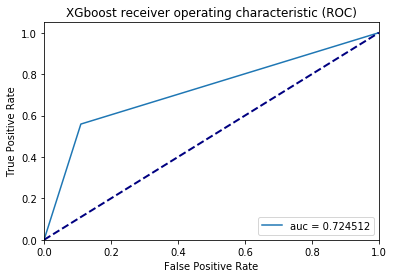

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fpr, tpr,label = "auc = " + str(format(auc,'.6f')))
plt.legend(loc = 4)
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGboost receiver operating characteristic (ROC)')
plt.show()

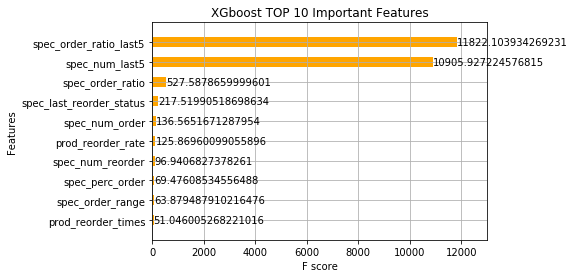

In [12]:
ax = xgb.plot_importance(model, importance_type = "gain", max_num_features = 10, height = 0.5, show_values = True, color = "orange")
fig = ax.figure
fig.set_size_inches(6, 4)
plt.title('XGboost TOP 10 Important Features')
#fig.savefig('features.png')
plt.show()

### apply model on test data

In [13]:
#test = pd.read_csv("gdrive/My Drive/Colab Notebooks/instacart/test.csv")
test = pd.read_csv("test.csv")
test = test.set_index(['user_id', 'product_id'])

test.head(10)

,,user_num_orders,user_num_prods,user_num_distinct_prods,user_avg_num_prods,user_avg_interval,user_dow_std,user_hour_std,user_dow_median,user_hour_median,user_dow_most,...,prod_hour_std,prod_dow_median,prod_hour_median,prod_dow_most,prod_hour_most,order_dow,order_hour_of_day,days_since_prior_order,t_dow_orders,t_hour_orders
user_id,product_id,,,,,,,,,,,,,,,,,,,,,
8942,196,4,56,38,14.000000,21.250,1.414,4.360,3.5,9.5,4,...,3.727,3.0,12.0,1,10,4,8,30.0,3787215,1719973
24280,196,18,27,14,1.500000,17.390,1.382,2.635,2.0,13.0,2,...,3.727,3.0,12.0,1,10,4,8,2.0,3787215,1719973
34207,196,3,5,4,1.666667,3.000,1.000,2.518,3.0,9.0,2,...,3.727,3.0,12.0,1,10,4,8,21.0,3787215,1719973
42970,196,3,16,12,5.333333,19.670,0.577,7.023,5.0,16.0,5,...,3.727,3.0,12.0,1,10,4,8,30.0,3787215,1719973
60073,196,35,365,126,10.428571,9.800,2.693,4.668,1.0,17.0,0,...,3.727,3.0,12.0,1,10,4,8,11.0,3787215,1719973
65187,196,16,95,26,5.937500,20.060,1.408,2.834,3.0,11.0,2,...,3.727,3.0,12.0,1,10,4,8,30.0,3787215,1719973
70669,196,48,519,132,10.812500,6.105,2.184,3.088,3.0,13.0,5,...,3.727,3.0,12.0,1,10,4,8,2.0,3787215,1719973
70891,196,3,23,10,7.666667,12.336,1.527,2.518,3.0,10.0,1,...,3.727,3.0,12.0,1,10,4,8,1.0,3787215,1719973
84382,196,35,274,88,7.828571,6.000,1.711,3.120,2.0,11.0,1,...,3.727,3.0,12.0,1,10,4,8,3.0,3787215,1719973


In [14]:
test.shape

(4833292, 44)

In [15]:
xgtrain_1 = xgb.DMatrix(X, label = y)
xgtest_1 = xgb.DMatrix(test)

model = xgb.train(plst, xgtrain_1, num_rounds)

y_pred_real = model.predict(xgtest_1)

y_pred_real[y_pred_real >= cutoff] = 1
y_pred_real[y_pred_real < cutoff] = 0

y_pred_real = y_pred_real.astype(np.int16)
y_pred_real

array([1, 0, 1, ..., 0, 1, 0], dtype=int16)

In [16]:
test = test.reset_index()
test.head(10)
df_result_temp = test[['product_id', 'user_id']]
df_result_temp["prediction"] = y_pred_real
df_result_temp.head(10)

,product_id,user_id,prediction
0,196,8942,1
1,196,24280,0
2,196,34207,1
3,196,42970,1
4,196,60073,0
5,196,65187,0
6,196,70669,0
7,196,70891,1
8,196,84382,1
9,196,92575,1


In [17]:
#df_orders = pd.read_csv('gdrive/My Drive/Colab Notebooks/instacart/orders.csv')
df_orders = pd.read_csv('orders.csv')
df_test = df_orders.loc[df_orders.eval_set == 'test', ['user_id', 'order_id']]   # data for test
df_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [18]:
df_result_temp = df_result_temp.merge(df_test, on = 'user_id', how = 'left')
df_result_temp.to_csv("xgboostPrediction.csv", index = False)
df_result_temp.head()

,product_id,user_id,prediction,order_id
0,196,8942,1,363822
1,196,24280,0,391840
2,196,34207,1,3254668
3,196,42970,1,3144266
4,196,60073,0,3233771


In [19]:
#df_result = df_result.drop('user_id', axis = 1)
df_result_temp = df_result_temp.ix[df_result_temp["prediction"].astype('int') == 1]   # filter out prediction = 1
df_result_temp.head()

,product_id,user_id,prediction,order_id
0,196,8942,1,363822
2,196,34207,1,3254668
3,196,42970,1,3144266
7,196,70891,1,2928615
8,196,84382,1,3253930


In [20]:
def combine_products(x):
    return " ".join(list(x.astype('str')))
  
df_result = df_result_temp.groupby("order_id")["product_id"].aggregate(combine_products).reset_index()
df_result.columns = ["order_id", "products"]
df_result.head()

,order_id,products
0,17,21709 47766 38777 21463 13107
1,34,13176 47766 47792 21137 48523 44632 43504 3918...
2,137,41787 24852 21903 29594 5134 38689 25890 2326 ...
3,182,47209 11520 39275 13629 47672 5479 33000 12456...
4,257,49235 24852 27966 37646 47766 21137 22035 1387...


In [21]:
#df_sub = pd.read_csv("gdrive/My Drive/Colab Notebooks/instacart/sample_submission.csv", usecols=["order_id"])
df_sub = pd.read_csv("sample_submission.csv", usecols=["order_id"])
df_sub = pd.merge(df_sub, df_result, how = "left", on = "order_id")

# use Na when there are no predictions 
df_sub["products"].fillna(np.nan, inplace = True)

#df_sub.to_csv("gdrive/My Drive/Colab Notebooks/instacart/df_sub.csv", index = False)
df_sub.to_csv("df_sub.csv", index = False)
df_sub.head()

,order_id,products
0,17,21709 47766 38777 21463 13107
1,34,13176 47766 47792 21137 48523 44632 43504 3918...
2,137,41787 24852 21903 29594 5134 38689 25890 2326 ...
3,182,47209 11520 39275 13629 47672 5479 33000 12456...
4,257,49235 24852 27966 37646 47766 21137 22035 1387...
